###### Inicialização

In [ ]:
!pip install meteostat yfinance

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [ ]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

# Análise de Séries temporais (Sessão 11)
---
Modelando Séries (parte 2)

## Modelos de Média Móvel

### Motivação
Séries temporais de indicadores econômicos, por exemplo, são afetadas por uma variedade de eventos randômicos como greves, decisões governamentais, desastres naturais, déficits de commodities e etc.

Esses eventos não terão apenas um efeito imediato no indicador, mas poderá afetá-lo também em vários períodos consecutivos.

Assim, é plausível que um processo de média móvel apareça na prática!

Além disso, como veremos, suas propriedades matemáticas são complementares a aquelas dos processos autoregressivos.

### Definição
Modelos de média móvel são uma extensão do processo de ruído branco:

\begin{align}
X_t = ε_t + \beta_1ε_{t-1} + \beta_2ε_{t-2} + ... +\beta_qε_{t-q} = MA(q)
\end{align}

Isto é, uma combinação linear da corrente pertubação $ε_t$ mais as mais recentes $ε_{t-1}, ε_{t-2}, ... ε_{t-q}$.

$E_t$ é um processo de ruído branco, ou seja, é independente e identicamente distribuído, e também é independente de qualquer $X_s$, em que s < t.

Em muitos aspectos, os modelos de média móvel são complementares aos modelos autoregressivos.

#### Simulando um processo MA(1)

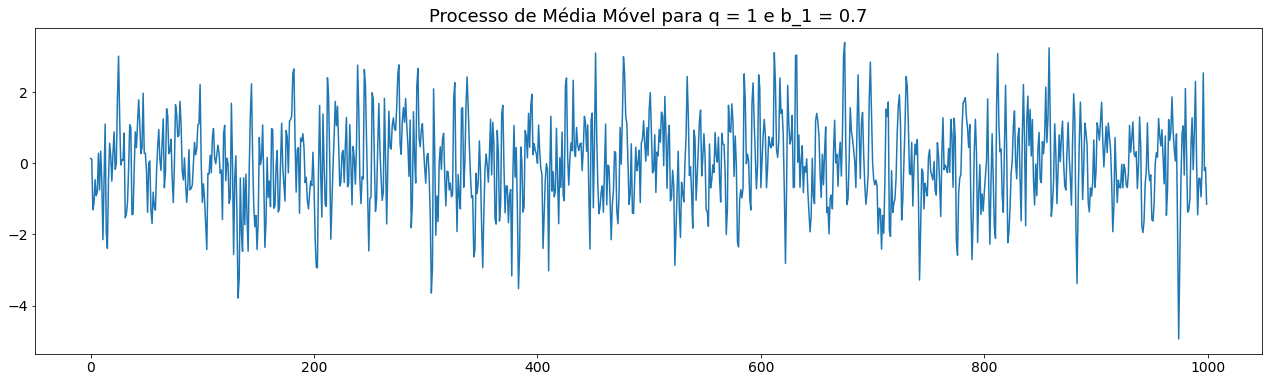

In [5]:
ar = np.array([1])
ma = np.array([1, 0.7])

serie_ma1 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_ma1 = pd.Series(serie_ma1)

_ = serie_ma1.plot(title = "Processo de Média Móvel para q = 1 e b_1 = 0.7")

#### Simulando um Processo MA(2)

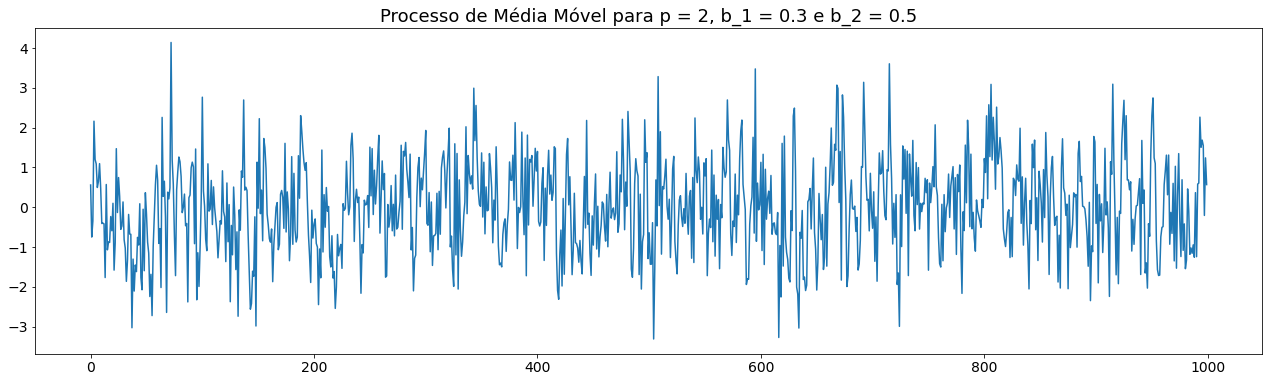

In [6]:
ar = np.array([1])
ma = np.array([1, .3, .5])

serie_ma2 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_ma2 = pd.Series(serie_ma2)

_ = serie_ma2.plot(title = "Processo de Média Móvel para p = 2, b_1 = 0.3 e b_2 = 0.5")

### Identificação do Modelo

A minha série é gerada a partir de um processo MA(q)?

1. A série temporal precisa ser necessariamente estacionária;
2. Apresentar aproximadamente uma função de autocorrelação com claro corte em algum passo $q$;
3. Apresentar uma função de autocorrelação parcial com decaimento gradual.

In [7]:
resultado_adf(sm.tsa.adfuller(serie_ma1))

Statistics=-10.346, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

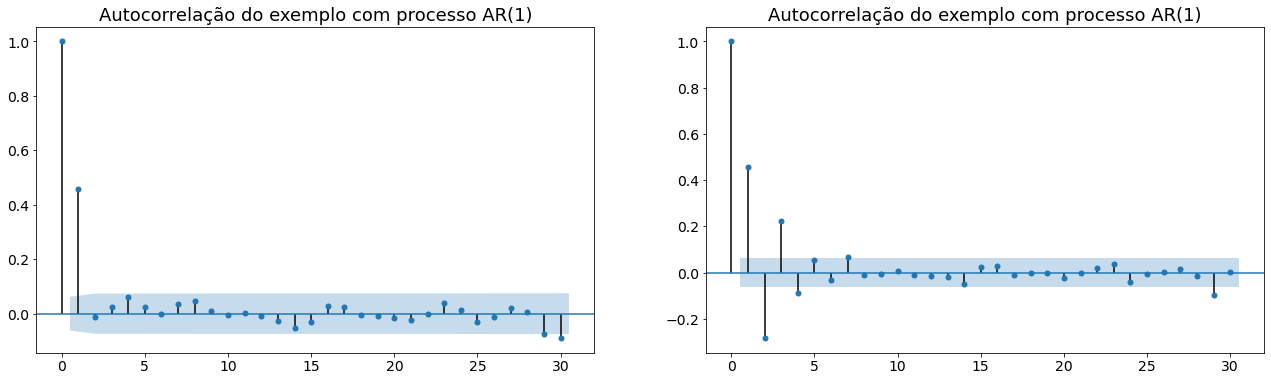

In [8]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_ma1, ax = axs[0], title="Autocorrelação do exemplo com processo AR(1)")
_ = tsa.plot_pacf(serie_ma1, ax = axs[1], title="Autocorrelação do exemplo com processo AR(1)")

In [9]:
resultado_adf(sm.tsa.adfuller(serie_ma2))

Statistics=-11.451, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

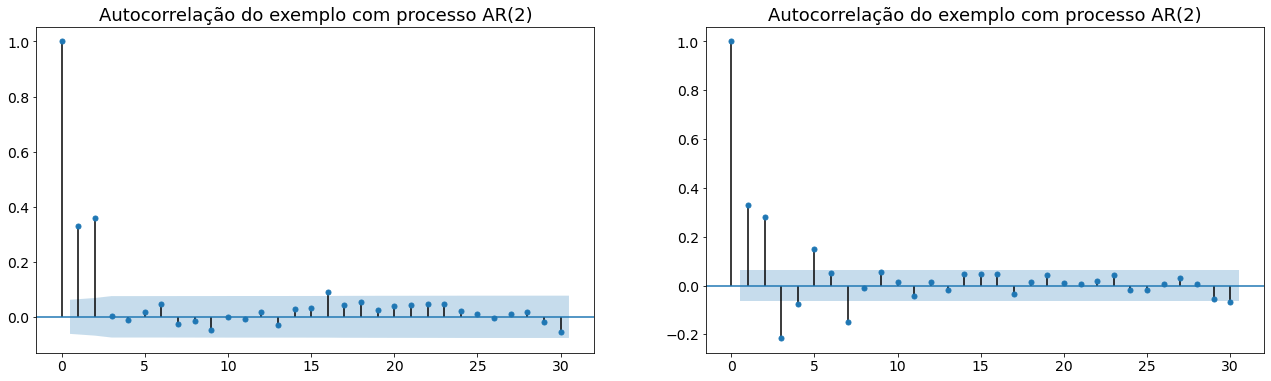

In [10]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_ma2, ax = axs[0], title="Autocorrelação do exemplo com processo AR(2)")
_ = tsa.plot_pacf(serie_ma2, ax = axs[1], title="Autocorrelação do exemplo com processo AR(2)")

### Ajustamento

O ajustamento (ou fitting) de modelos MA(q) a séries temporais é mais difícil que de modelos AR(p), porque não há estimadores explícitos (e eficientes) e, assim, é necessária otimização numérica.

Na prática, dois métodos são utilizados para ajustar um modelo MA(q):
1. A Soma Condicional dos Quadrados (ou Conditional Sum of Squares) (CSS)
  - Um método numérico de minimização da soma dos quadrados dos resíduos.
2. A Estimativa da Máxima Verossimilhança (MLE)
  - Baseado em que a pertubação Et segue uma distribuição normal ($X_t= m + ε_t + β_1ε_{t-1} + β_2ε_{t-2} + ... + β_qε_{t-q}$)
  - Para um melhor desempenho da MLE, os valores iniciais dos coeficientes são obtidos do CSS

Evite uma quantidade massiva de extremos (outliers) ou dados extremamente assimétricos. Nesses casos, uma transformação-log é ideal antes de modelar.

#### Ajustando o Modelo MA(1)

In [11]:
modelo_ma1 = sm.tsa.arima.ARIMA(serie_ma1, order=(0,0,1)).fit()

In [12]:
print(modelo_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1413.708
Date:                Tue, 14 Feb 2023   AIC                           2833.416
Time:                        01:23:56   BIC                           2848.139
Sample:                             0   HQIC                          2839.012
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0081      0.053     -0.153      0.878      -0.112       0.095
ma.L1          0.6804      0.023     30.099      0.000       0.636       0.725
sigma2         0.9890      0.042     23.506      0.0

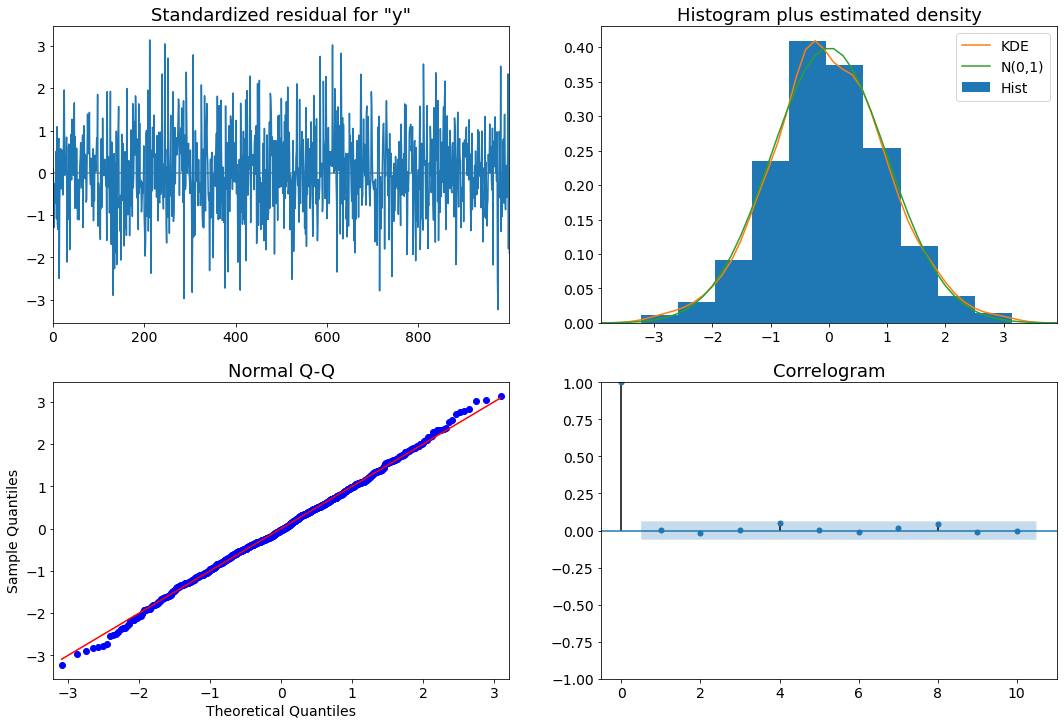

In [13]:
modelo_ma1.plot_diagnostics(figsize=(18,12));

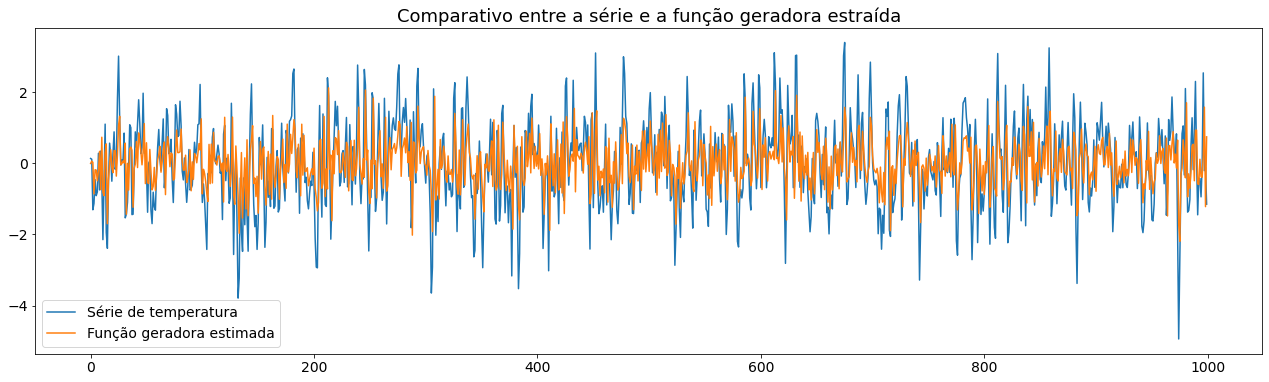

In [14]:
ax = serie_ma1.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_ma1.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

#### Ajustando o Modelo MA(2)

In [15]:
modelo_ma2 = sm.tsa.arima.ARIMA(serie_ma2, order=(0,0,2)).fit()

In [16]:
print(modelo_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1423.976
Date:                Tue, 14 Feb 2023   AIC                           2855.952
Time:                        01:27:55   BIC                           2875.583
Sample:                             0   HQIC                          2863.413
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.058     -0.002      0.998      -0.114       0.113
ma.L1          0.2745      0.027     10.026      0.000       0.221       0.328
ma.L2          0.5356      0.026     20.315      0.0

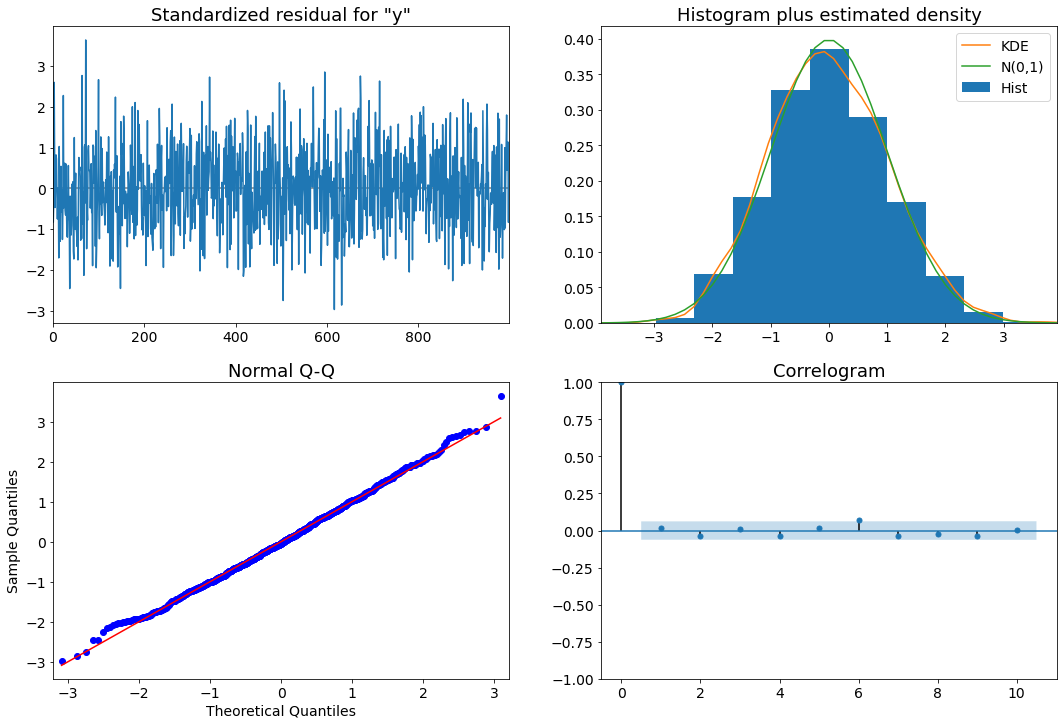

In [17]:
modelo_ma2.plot_diagnostics(figsize=(18,12));

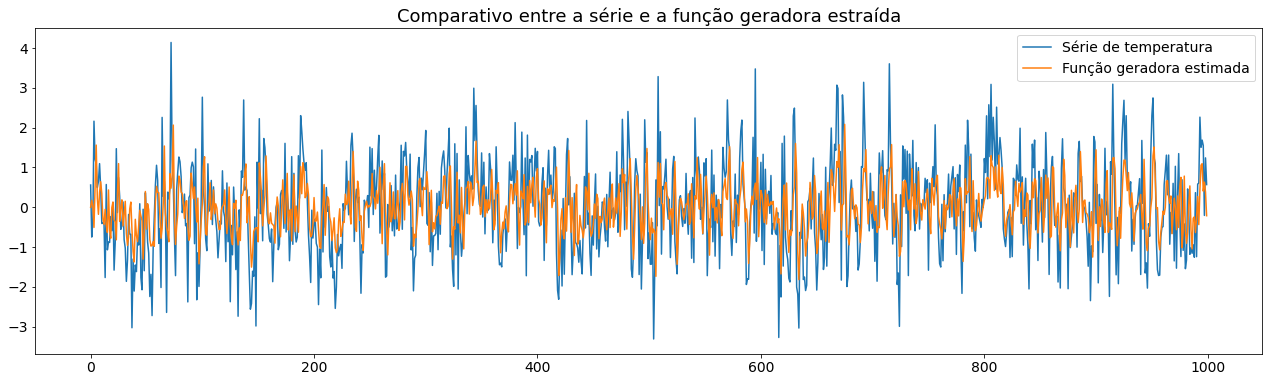

In [18]:
ax = serie_ma2.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_ma2.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

### Aplicações

In [19]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [20]:
y_aracaju_dif = ( serie_aracaju.tavg - serie_aracaju.tavg.mean() ).dropna().diff()[1:]

In [21]:
resultado_adf(sm.tsa.adfuller(y_aracaju_dif))

Statistics=-14.581, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

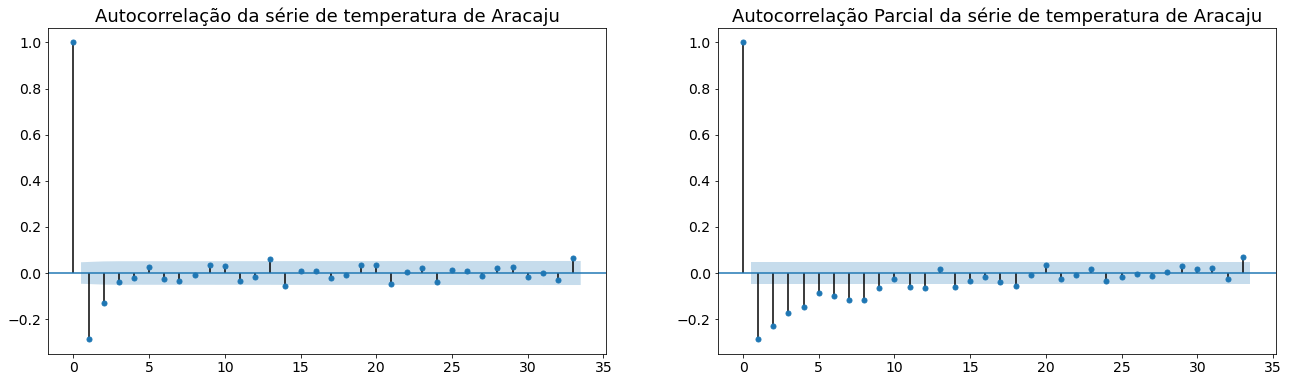

In [22]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(y_aracaju_dif, ax = axs[0], title="Autocorrelação da série de temperatura de Aracaju")
_ = tsa.plot_pacf(y_aracaju_dif, ax = axs[1], title="Autocorrelação Parcial da série de temperatura de Aracaju")

In [23]:
modelo_temperatura_ma = sm.tsa.arima.ARIMA(y_aracaju_dif, order=(0,0,2)).fit()

In [24]:
print(modelo_temperatura_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                 1764
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1749.754
Date:                Tue, 14 Feb 2023   AIC                           3507.508
Time:                        01:30:39   BIC                           3529.410
Sample:                    01-02-2018   HQIC                          3515.601
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.095      0.924      -0.009       0.008
ma.L1         -0.5030      0.021    -24.432      0.000      -0.543      -0.463
ma.L2         -0.2665      0.021    -12.528      0.0

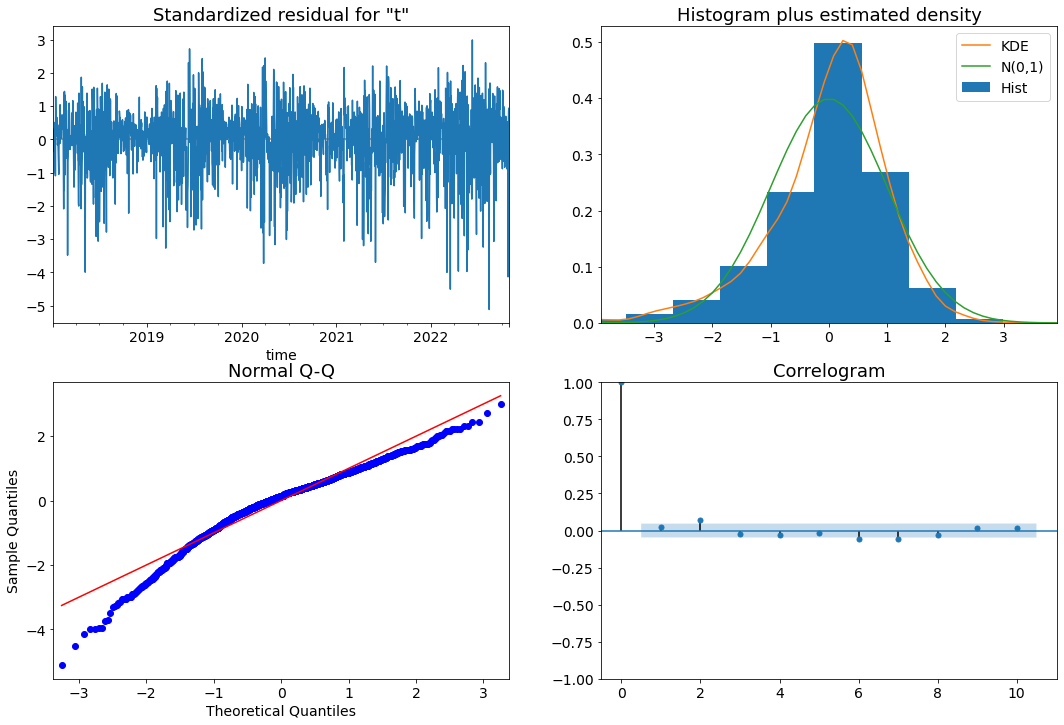

In [25]:
modelo_temperatura_ma.plot_diagnostics(figsize=(18,12));

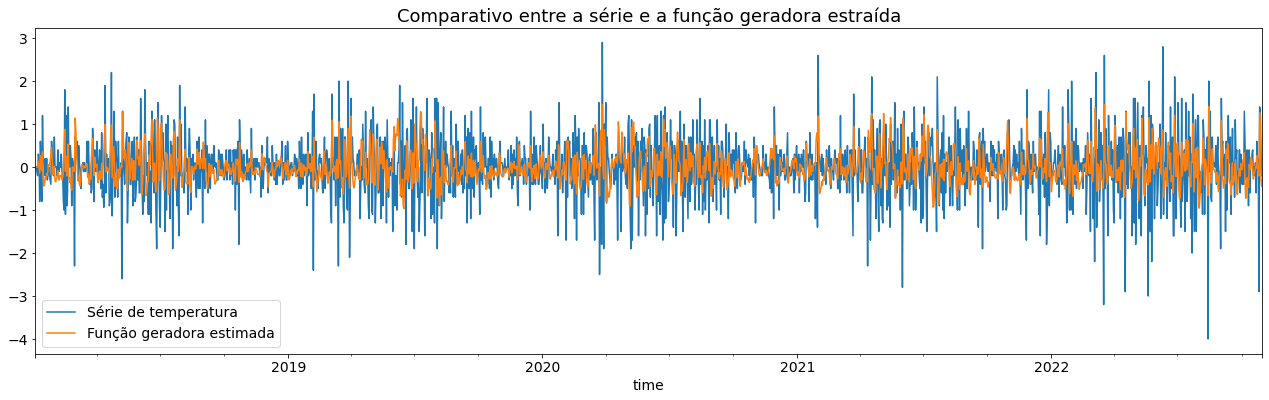

In [26]:
ax = y_aracaju_dif.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_ma.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

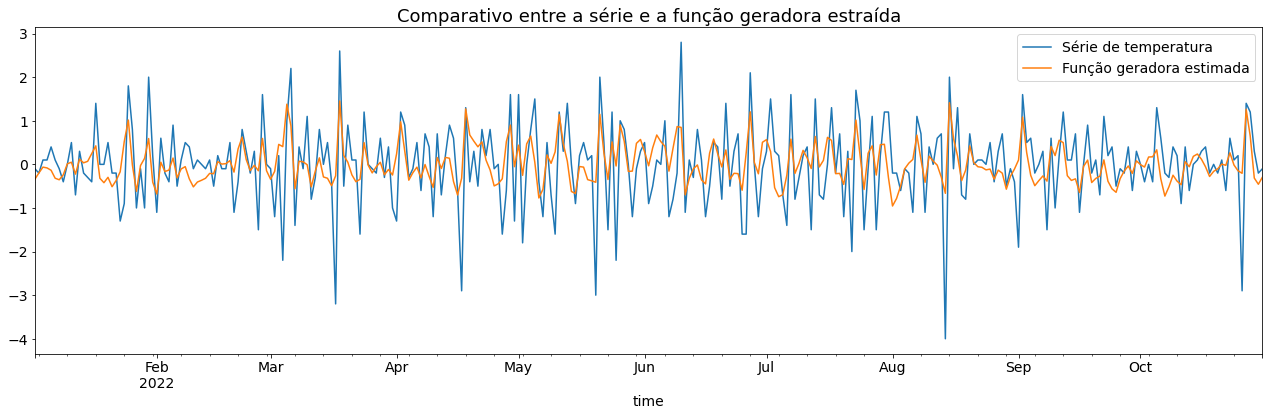

In [27]:
ax = y_aracaju_dif[y_aracaju_dif.index > "2022-01-01"].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_ma.fittedvalues[modelo_temperatura_ma.fittedvalues.index > "2022-01-01"].plot(ax = ax, label="Função geradora estimada", legend= True)

## Exercício

1. Ajuste um modelo de média móvel para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo. Não esquecer de:
   - Ajustar a média para 0
  - Tornar a série estacionária
  - Valida se a série é estacionária utilizando o teste de estacionariedade.
2. Realize o mesmo procedimento para a série de câmbio dólar/real